In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib

In [3]:
# %matplotlib widget
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from calendar import month_name, month_abbr
import dateparser

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs

### plotting 
from matplotlib import pyplot as plt
import palettable

In [4]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### import local functions for the downloading of the C3S forecasts 

In [5]:
sys.path.append('../..')

In [6]:
from ICU_Water_Watch import geo, C3S, domains, plot, utils

/home/nicolasf/mambaforge/envs/ICU_ops/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [7]:
domains.domains

{'Tropical_Pacific': [140, 220, -25, 25],
 'SW_Pacific': [172.5, 190, -22.5, -12],
 'Fiji': [175, 183, -21, -15],
 'NZ': [161, 181, -50, -30],
 'Pacific': [140, 240, -50, 25],
 'C3S_download': [100, 240, -50, 30],
 'Water_Watch': [125, 240, -35, 25]}

### parameters for papermill

In [8]:
# Parameters
period = "seasonal"
lead = 3
date = "this month"


In [9]:
domain_name = 'Water_Watch' # domain name 
date = "last month"
period = "seasonal"
lead = 1
quantile = 'decile'
varname = 'precip'
dpath_shapes = '/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles'
dpath_forecasts = '/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/C3S'
fpath = '/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/figures/C3S'
fpath_web = '/home/nicolasf/operational/ICU_Web/C3S/'

### casts the paths to pathlib.Paths 

In [10]:
dpath_shapes = pathlib.Path(dpath_shapes)
dpath_forecasts = pathlib.Path(dpath_forecasts)
fpath = pathlib.Path(fpath)
fpath_web = pathlib.Path(fpath_web)

### domain 

In [11]:
domain = domains.domains[domain_name]

### EEZ shapes 

In [12]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes)

### year and month (initial month of the forecast)

In [13]:
year = dateparser.parse(date).year

In [14]:
month = dateparser.parse(date).month

In [15]:
print(f"{year} - {month}")

2022 - 2


### provider 

In [16]:
provider = 'CDS'

#### list of GCMs to inlude 

In [17]:
list_GCMs = ['ECMWF','UKMO','METEO_FRANCE','CMCC','DWD', 'NCEP', 'JMA', 'ECCC_CanCM4i', 'ECCC_GEM_NEMO']

### what is the first step and the number of steps in either the monthly or seasonal forecasts 

In [18]:
if period == 'seasonal': 
    nsteps = 3
    first_step = 3
elif period == 'monthly': 
    nsteps = 5
    first_step = 1

In [19]:
step = lead + first_step - 1

In [20]:
step

3

### paths to the realtime forecasts

In [21]:
dpath_forecasts = CWD.parents[1].joinpath("outputs/C3S")

In [22]:
dpath_forecasts

PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/C3S')

In [23]:
lfiles = list(dpath_forecasts.glob(f"{period}_{quantile}s_probabilities_from_{year}-{str(month).zfill(2)}_*.netcdf"))

### checks the files names 

In [24]:
[f.name for f in lfiles]

['seasonal_deciles_probabilities_from_2022-02_ECCC_CanCM4i.netcdf',
 'seasonal_deciles_probabilities_from_2022-02_ECMWF.netcdf',
 'seasonal_deciles_probabilities_from_2022-02_UKMO.netcdf',
 'seasonal_deciles_probabilities_from_2022-02_METEO_FRANCE.netcdf',
 'seasonal_deciles_probabilities_from_2022-02_CMCC.netcdf',
 'seasonal_deciles_probabilities_from_2022-02_JMA.netcdf',
 'seasonal_deciles_probabilities_from_2022-02_ECCC_GEM_NEMO.netcdf',
 'seasonal_deciles_probabilities_from_2022-02_NCEP.netcdf',
 'seasonal_deciles_probabilities_from_2022-02_DWD.netcdf']

### open the multiple files dataset, concatenate along the "GCM" dimension 

In [25]:
probs = xr.open_mfdataset(lfiles, concat_dim='GCM', combine='nested', engine='netcdf4') 

In [26]:
probs

,Array,Chunk
Bytes,20.19 MiB,2.24 MiB
Shape,"(9, 10, 1, 3, 81, 121)","(1, 10, 1, 3, 81, 121)"
Count,27 Tasks,9 Chunks
Type,float64,numpy.ndarray


### interpolate

In [27]:
probs = utils.interp(probs, interp_factor=6)

In [28]:
probs

,Array,Chunk
Bytes,726.82 MiB,80.76 MiB
Shape,"(9, 10, 1, 3, 486, 726)","(1, 10, 1, 3, 486, 726)"
Count,71 Tasks,9 Chunks
Type,float64,numpy.ndarray


In [29]:
probs = probs.mean('GCM')

### make sure the probabilities sum to 100 over the decile dimension 

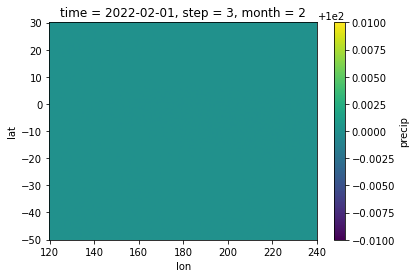

In [30]:
probs.sum('decile').squeeze().sel(step=3)['precip'].plot(vmin=99.99, vmax=100.01)

### Now calculates the cumulative probabilities over the decile dimension 

In [31]:
cum_probs = probs.cumsum('decile', keep_attrs=True)

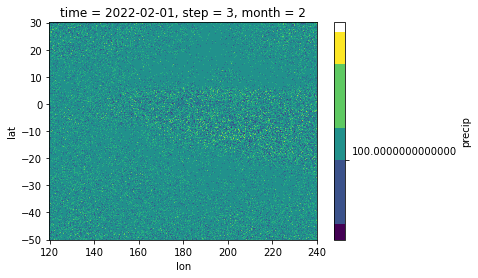

In [32]:
cum_probs.isel(decile=-1).sel(step=step).squeeze()['precip'].plot()

In [33]:
cum_probs

<xarray.Dataset>
Dimensions:  (decile: 10, time: 1, step: 3, lat: 486, lon: 726)
Coordinates:
  * time     (time) datetime64[ns] 2022-02-01
  * step     (step) int64 3 4 5
    month    int64 2
  * lon      (lon) float64 120.0 120.2 120.3 120.5 ... 239.5 239.7 239.8 240.0
  * lat      (lat) float64 -50.0 -49.84 -49.67 -49.51 ... 29.51 29.67 29.84 30.0
Dimensions without coordinates: decile
Data variables:
    precip   (decile, time, step, lat, lon) float64 dask.array<chunksize=(10, 1, 3, 486, 726), meta=np.ndarray>

### recode the decile values, so they go from 1 to 10 instead of 0 to 9 

In [34]:
cum_probs.decile

<xarray.DataArray 'decile' (decile: 10)>
array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Coordinates:
    month    int64 2
Dimensions without coordinates: decile

In [35]:
cum_probs['decile'] = cum_probs['decile'] + 1

In [36]:
cum_probs.decile

<xarray.DataArray 'decile' (decile: 10)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
Coordinates:
    month    int64 2
  * decile   (decile) int64 1 2 3 4 5 6 7 8 9 10

#### selects probabilities greater or equal than 50% 

In [37]:
cum_probs = cum_probs.where(cum_probs['precip'] >= 50)

### quick plot of the minimum decile value for the cumulative decile probabilities reaching 50% 

Text(0.5, 1.0, '')

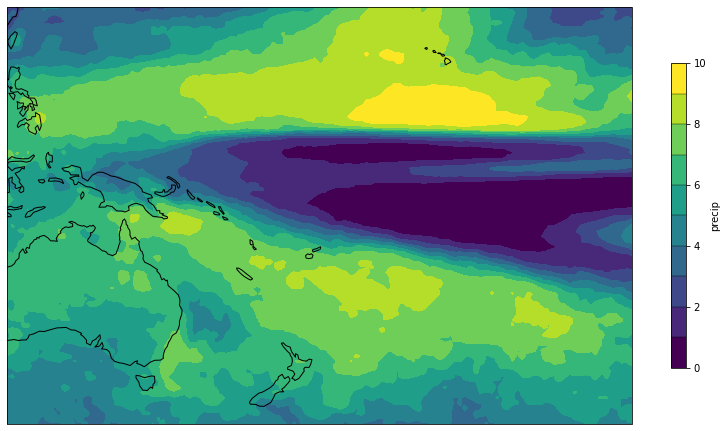

In [38]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)), figsize=(14,8))

cum_probs.idxmin('decile').squeeze().sel(step=step)['precip'].plot.contourf(ax=ax, levels=np.arange(0, 11), transform=ccrs.PlateCarree(), \
                                                                   cbar_kwargs={'shrink':0.7, 'boundaries':np.arange(11), 'drawedges':True})
ax.coastlines()

ax.set_title('')

### Now starts the prototype plotting 

In [39]:
thresholds = np.arange(0.5, 10.5 + 1, 1)

In [40]:
thresholds

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5])

In [41]:
ticks_marks = np.diff(np.array(thresholds)) / 2.

ticks = [thresholds[i] + ticks_marks[i] for i in range(len(thresholds) - 1)]

In [42]:
ticks

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

In [43]:
hexes = ['#003c30', '#01665e', '#35978f', '#80cdc1', '#c7eae5', '#f6e8c3', '#dfc27d', '#bf812d', '#8c510a', '#543005']

In [44]:
hexes.reverse()

In [45]:
cbar_ticklabels = ['>90th', '80-90th', '70-80th', '60-70th', '50-60th', '40-50th', '30-40th', '20-30th', '10-20th', '< 10th']

In [46]:
cbar_ticklabels.reverse()

In [47]:
cbar_ticklabels

['< 10th',
 '10-20th',
 '20-30th',
 '30-40th',
 '40-50th',
 '50-60th',
 '60-70th',
 '70-80th',
 '80-90th',
 '>90th']

In [48]:
import matplotlib

In [49]:
cmap = matplotlib.colors.ListedColormap(hexes, name='decile')

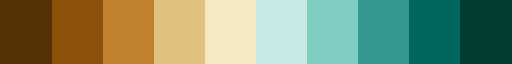

In [50]:
cmap

In [51]:
decile_map = cum_probs.idxmin('decile').squeeze().sel(step=step)

In [52]:
merged_EEZs

,index,geometry
0,EEZ,"POLYGON ((188.63281 -22.23893, 188.62887 -22.2..."


In [53]:
decile_map = geo.make_mask_from_gpd(decile_map, merged_EEZs, subset=False, insert=True)

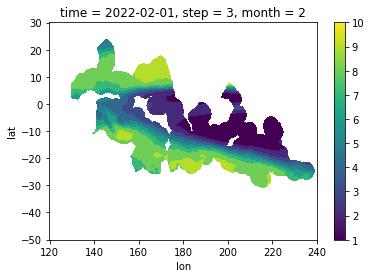

In [54]:
(decile_map['precip'] * decile_map['mask']).plot()

In [55]:
month_name = list(month_name)

In [56]:
month_name += month_name[1:]

In [57]:
if period == 'monthly': 
    label_period = month_name[month + step]
elif period == 'seasonal': 
    label_period = month_name[month + step - 2] + " - " + month_name[month + step]

In [58]:
step

3

In [59]:
label_period

'March - May'

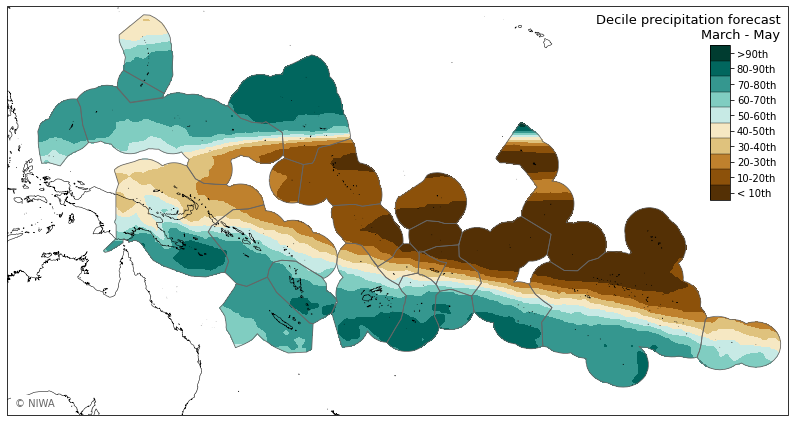

In [60]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)), figsize=(14,8))

ff = (decile_map['precip'] * decile_map['mask']).plot.contourf(ax=ax, levels=thresholds, cmap=cmap, transform=ccrs.PlateCarree(), add_colorbar=False)

ax.coastlines(resolution='10m', lw=0.5)

ax.set_title('')

cbar_kwargs={'shrink':0.5, 'pad':0.01, 'extend':'neither', 'drawedges':True, 'ticks':ticks, 'aspect':15}

cbar_ax = ax.axes.inset_axes([0.9, 0.525, 0.025, 0.38])

cb = plt.colorbar(ff, cax=cbar_ax, **cbar_kwargs)

cb.ax.minorticks_off()

cbar_ax.set_yticklabels(cbar_ticklabels)

plot.add_geom(ax, geoms=EEZs)

title = f"Decile precipitation forecast\n{label_period}"

ax.text(0.99, 0.95, title, fontsize=13, fontdict={'color':'k'}, bbox=dict(facecolor='w', edgecolor='w'), horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)

ax.text(0.01, 0.02, u'\u00A9'+" NIWA", transform=ax.transAxes, bbox=dict(facecolor='w', edgecolor='w'), fontdict=dict(color='0.4'))

# ax.text(0.99, 0.02, "(first decile value where cumulative probability reaches 50%)",transform=ax.transAxes, horizontalalignment='right')

ax.set_extent(domain, crs = ccrs.PlateCarree())

In [61]:
f.savefig(fpath.joinpath(f'decile_forecast_prototype_{period}_{year}_{month:02d}_init_{label_period.replace(" - ","_")}.png'), dpi=200, facecolor='w', bbox_inches='tight')

In [62]:
f.savefig(fpath_web.joinpath(f'decile_forecast_prototype_{period}_lead{lead}_latest.png'), dpi=200, facecolor='w', bbox_inches='tight')

### create station heatmap 

In [63]:
station_name = 'Nadi'
lon = 177.4356
lat = -17.7765

In [64]:
probs_station = probs.sel(lat=lat, lon=lon, method='nearest')

In [65]:
probs_station_df = probs_station.squeeze()[['precip']].to_dataframe()['precip']

In [66]:
probs_station_df = probs_station_df.unstack()

In [67]:
probs_station_df

step,3,4,5
decile,,,
1,1.333646,0.562974,1.549806
2,2.502271,3.245111,2.798049
3,3.996304,4.885098,3.970615
4,6.306327,6.990654,6.661643
5,8.464626,6.910581,8.301480
6,8.903179,8.892342,10.033715
7,13.211903,13.207538,12.108944
8,13.849234,16.354968,16.174353
9,17.548359,16.370860,15.680698


In [68]:
if period == 'seasonal': 
    n_steps = 3
elif period == 'monthly': 
    n_steps = 5

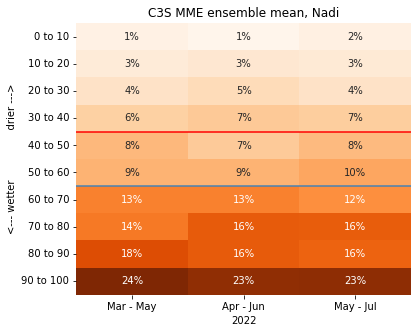

In [69]:
f, ax = plot.plot_heatmap(probs_station_df, period=period, n_steps=n_steps, year=2022, cmap='Oranges_r', title=f'C3S MME ensemble mean, Nadi', cumsum=False, start_month=month + 1)

In [70]:
f.savefig(fpath.joinpath(f'{station_name}_{period}_from_{year}_{month}.png'), dpi=200, bbox_inches='tight', facecolor='w')